## 01 - Importing Weather Data Set



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VcvN93ndl18UhuUcpGGI")
project = rf.workspace("cv-aal82").project("369")
dataset = project.version(1).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=69a0aceaa2363b5846a297ab87b2e535129c499c29e17d346515f34dede3d74e
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pypar

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to 369-1 in folder:: 100%|██████████| 1482/1482 [00:00<00:00, 1917.42it/s]


FileNotFoundError: ignored

## 03 - Image Processing anda Data Augmentation


In [ ]:
!mkdir preview/


datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/369-1/train/shine/shine105_jpg.rf.859d7ef593cfea4db7f3b060a2d9b84d.jpg')  # this is a PIL image
x = tf.keras.utils.img_to_array(img)  # this is a Numpy array with shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='rain', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 150

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/369-1/train', 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/content/369-1/valid', 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_generator = validation_datagen.flow_from_directory(
        '/content/369-1/test', 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 1026 images belonging to 5 classes.
Found 293 images belonging to 5 classes.
Found 143 images belonging to 5 classes.


## 04 - Model Implementation


### Model 2 Architecture


In [ ]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(pooling_layer)
conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

#FC - Fully connected
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(5, activation="softmax")(dropout)

model2 = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                             

## 05 - Training Model



### Training Model 2

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("model_2.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)
history2 = model2.fit(train_generator,validation_data=validation_generator, epochs=50,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.3959 - accuracy: 0.3986
Epoch 1: val_accuracy improved from -inf to 0.43003, saving model to model_2.h5
33/33 [==============================] - 23s 437ms/step - loss: 1.3959 - accuracy: 0.3986 - val_loss: 1.1600 - val_accuracy: 0.4300
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.1774 - accuracy: 0.5019
Epoch 2: val_accuracy improved from 0.43003 to 0.50853, saving model to model_2.h5
33/33 [==============================] - 14s 425ms/step - loss: 1.1774 - accuracy: 0.5019 - val_loss: 1.0816 - val_accuracy: 0.5085
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.5848
Epoch 3: val_accuracy improved from 0.50853 to 0.69966, saving model to model_2.h5
33/33 [==============================] - 15s 466ms/step - loss: 1.0219 - accuracy: 0.5848 - val_loss: 0.8289 - val_accuracy: 0.6997
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 0.9051 -

## 06 - Loss and Accuracy Plotting

In [ ]:
import matplotlib.pyplot as plt
def plot_curves(history):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right');

### Plotting Model Performance 2

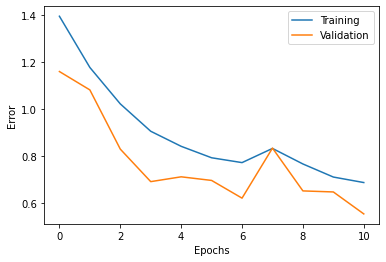

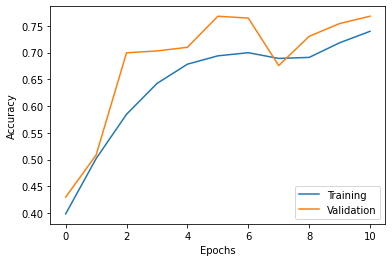

In [ ]:
plot_curves(history2.history)

## 07 - Preliminar Scores (Training & Validation)

### Scores Model 2

In [ ]:
scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

33/33 [==============================] - 11s 336ms/step - loss: 0.5368 - accuracy: 0.7973
Train loss    : 0.5368228554725647
Train accuracy: 0.7972709536552429
10/10 [==============================] - 2s 240ms/step - loss: 0.5524 - accuracy: 0.7679
Val loss    : 0.5523874163627625
Val accuracy: 0.7679181098937988
5/5 [==============================] - 2s 307ms/step - loss: 0.5621 - accuracy: 0.8182
Test loss    : 0.5621068477630615
Test accuracy: 0.8181818127632141


## 08 - Transfer Learning Model

### Importing Pretrained Model (VGG16)

In [ ]:
#importing VGG16 model, weights and freeze
from tensorflow.keras.applications import VGG16
vgg16_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(vgg16_base.summary())

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

### Implementing transfer model

In [ ]:
keras.backend.clear_session() #clear model numbers

for layer in vgg16_base.layers:
    layer.trainable = False
    
model_t = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16_base,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation='relu'),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation='relu'),           
        keras.layers.Dense(5, activation='softmax')    
    ])

model_t.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 19,042,117
Trainable params: 4,327,429
Non

### Training Transfer Model

In [ ]:
#training
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("model_vgg16.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)
history3 = model_t.fit(train_generator,validation_data=validation_generator, epochs=50,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.1592 - accuracy: 0.5458
Epoch 1: val_accuracy improved from -inf to 0.77474, saving model to model_vgg16.h5
33/33 [==============================] - 19s 484ms/step - loss: 1.1592 - accuracy: 0.5458 - val_loss: 0.6140 - val_accuracy: 0.7747
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.7437
Epoch 2: val_accuracy improved from 0.77474 to 0.82253, saving model to model_vgg16.h5
33/33 [==============================] - 14s 437ms/step - loss: 0.6992 - accuracy: 0.7437 - val_loss: 0.4854 - val_accuracy: 0.8225
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.7778
Epoch 3: val_accuracy improved from 0.82253 to 0.82594, saving model to model_vgg16.h5
33/33 [==============================] - 15s 450ms/step - loss: 0.5974 - accuracy: 0.7778 - val_loss: 0.4579 - val_accuracy: 0.8259
Epoch 4/50
33/33 [==============================] - ETA: 0s - lo

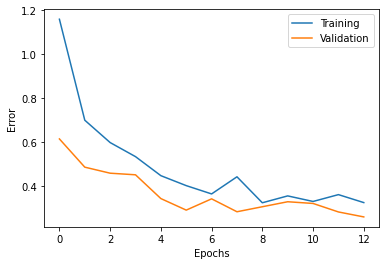

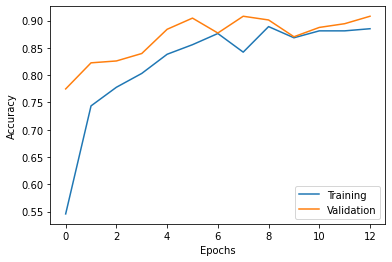

In [ ]:
plot_curves(history3.history)

In [ ]:
scores_tr = model_t.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model_t.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model_t.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

33/33 [==============================] - 11s 330ms/step - loss: 0.1934 - accuracy: 0.9337
Train loss    : 0.1934196650981903
Train accuracy: 0.9337232112884521
10/10 [==============================] - 2s 172ms/step - loss: 0.2587 - accuracy: 0.9078
Val loss    : 0.2586897015571594
Val accuracy: 0.9078498482704163
5/5 [==============================] - 2s 513ms/step - loss: 0.2714 - accuracy: 0.9021
Test loss    : 0.2713995575904846
Test accuracy: 0.9020978808403015


## 09 - Final Scores (Test)






In [ ]:
#model2
scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

#model with transfer learning
scores_tr = model_t.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])



5/5 [==============================] - 1s 148ms/step - loss: 0.5621 - accuracy: 0.8182
Test loss    : 0.5621068477630615
Test accuracy: 0.8181818127632141
5/5 [==============================] - 1s 163ms/step - loss: 0.2714 - accuracy: 0.9021
Test loss    : 0.2713995575904846
Test accuracy: 0.9020978808403015


## 10 - Predictions

In [ ]:
#print classes indices
indices = train_generator.class_indices
print(indices)

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}


### Good predictions

1/1 [==============================] - 0s 20ms/step
Real: rainy ,Predicted: rainy


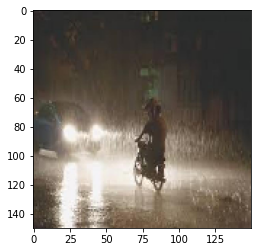

In [ ]:
#prediction for rain samples
path = '/content/369-1/test/rainy/rain189_jpg.rf.787f0b217d70e43eacb3393790f4643b.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: rainy', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 22ms/step
Real: foggy ,Predicted: foggy


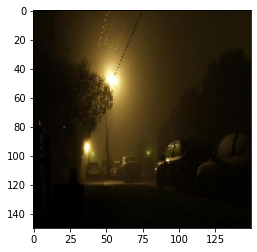

In [ ]:
#prediction for fogsmog samples
path = '/content/369-1/test/foggy/foggy244_jpg.rf.e0d845bbd8e17028b6cfe6d89e9a844f.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: foggy', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 20ms/step
Real: sunrise ,Predicted: sunrise


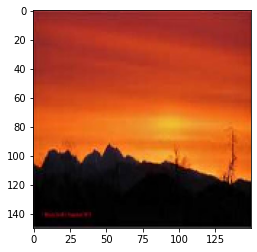

In [ ]:
#prediction for snow samples
path = '/content/369-1/test/sunrise/sunrise239_jpg.rf.ddf6a5ccfe73a668f3ee392a9a2b7e61.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: sunrise', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 22ms/step
Real: shine ,Predicted: shine


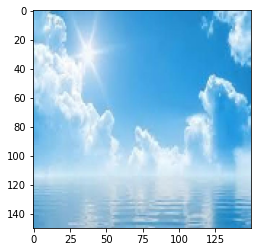

In [ ]:
#prediction for sunrise samples
path = '/content/369-1/test/shine/shine47_jpg.rf.b80cad8ab07412e1e3810aeff733a7f6.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: shine', ',Predicted:',list(indices.keys())[max_index])

### Bad predictions

1/1 [==============================] - 0s 19ms/step
Real: foggy ,Predicted: rainy


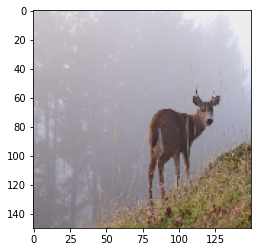

In [ ]:
#prediction for sunrise samples
path = '/content/369-1/test/foggy/foggy9_jpg.rf.c120902b9fa2a2f618ccf91058776217.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: foggy', ',Predicted:',list(indices.keys())[max_index])

1/1 [==============================] - 0s 21ms/step
Real: rainy ,Predicted: sunrise


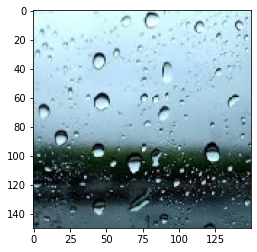

In [ ]:
#prediction for rain samples
path = '/content/369-1/test/rainy/rain82_jpg.rf.9cc35388b8eb0e3a1683eb2bab8d04ed.jpg'
img=load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
x=tf.keras.utils.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model_t.predict(images)
plt.imshow(img)

max_value = max(classes[0])
max_index = list(classes[0]).index(max_value)

np.around(classes[0], decimals = 2)
print('Real: rainy', ',Predicted:',list(indices.keys())[max_index])